# HW04 - ChBE 413
**Name:** Mikkel Flores  
**Due Date:** September 25, 2025

**General Imports**

In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from scipy.stats import pearsonr
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdFingerprintGenerator, Draw, rdMolDescriptors

# Question 1: Regression with Cross-Validation

**Part a**

Initializing and Sorting Data

In [70]:
df = pd.read_csv("Solubility.csv")
df = df.head(1000)
num_dupes = df.duplicated().sum()
missing_vals = df.isna().sum()
summary_stats = df.describe()

feature_cols = ["MolLogP", "NumHAcceptors", "NumHDonors", "NumAromaticRings"]
target_col = "Solubility"

x = df[feature_cols]
y = df[target_col]

In [71]:
print("Number of duplicate rows:", num_dupes)
print("\nMissing values per column:\n", missing_vals)
print("\nSummary statistics:\n", summary_stats)

Number of duplicate rows: 0

Missing values per column:
 ID                     0
Name                   0
InChI                  0
InChIKey               0
SMILES                 0
Solubility             0
SD                     0
Ocurrences             0
Group                  0
MolWt                  0
MolLogP                0
MolMR                  0
HeavyAtomCount         0
NumHAcceptors          0
NumHDonors             0
NumHeteroatoms         0
NumRotatableBonds      0
NumValenceElectrons    0
NumAromaticRings       0
NumSaturatedRings      0
NumAliphaticRings      0
RingCount              0
TPSA                   0
LabuteASA              0
BalabanJ               0
BertzCT                0
dtype: int64

Summary statistics:
         Solubility           SD   Ocurrences        MolWt      MolLogP  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -3.209605     0.119941     1.713000   262.406774     2.373926   
std       1.506016     0.314014     

In [72]:
print("Feature matrix shape:", x.shape)
print("Target vector shape:", y.shape)

print("\nFirst 5 rows of features:\n", x.head())
print("\nFirst 5 values of target:\n", y.head())

Feature matrix shape: (1000, 4)
Target vector shape: (1000,)

First 5 rows of features:
    MolLogP  NumHAcceptors  NumHDonors  NumAromaticRings
0   3.9581              0           0                 0
1   2.4055              1           1                 2
2   2.1525              1           0                 1
3   8.1161              6           2                 6
4   2.4854              6           0                 2

First 5 values of target:
 0   -3.616127
1   -3.254767
2   -2.177078
3   -3.924409
4   -4.662065
Name: Solubility, dtype: float64


No dupes of missing vals found in entire dataset. Restricted to first 1000 rows and selected the features to predict the target


Reduced df shape: (1000, 5)
   MolLogP  NumHAcceptors  NumHDonors  NumAromaticRings  Solubility
0   3.9581              0           0                 0   -3.616127
1   2.4055              1           1                 2   -3.254767
2   2.1525              1           0                 1   -2.177078
3   8.1161              6           2                 6   -3.924409
4   2.4854              6           0                 2   -4.662065


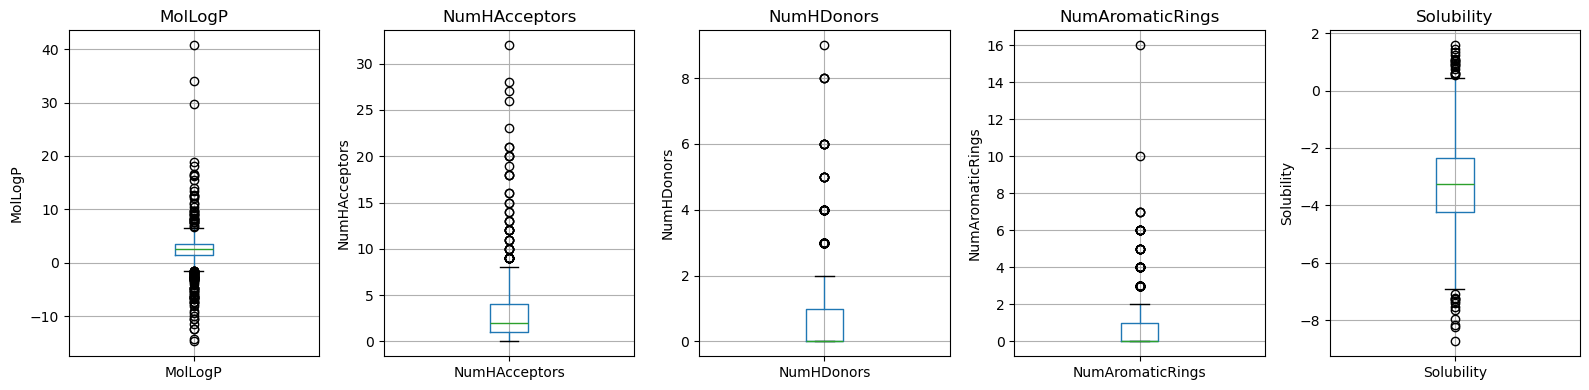

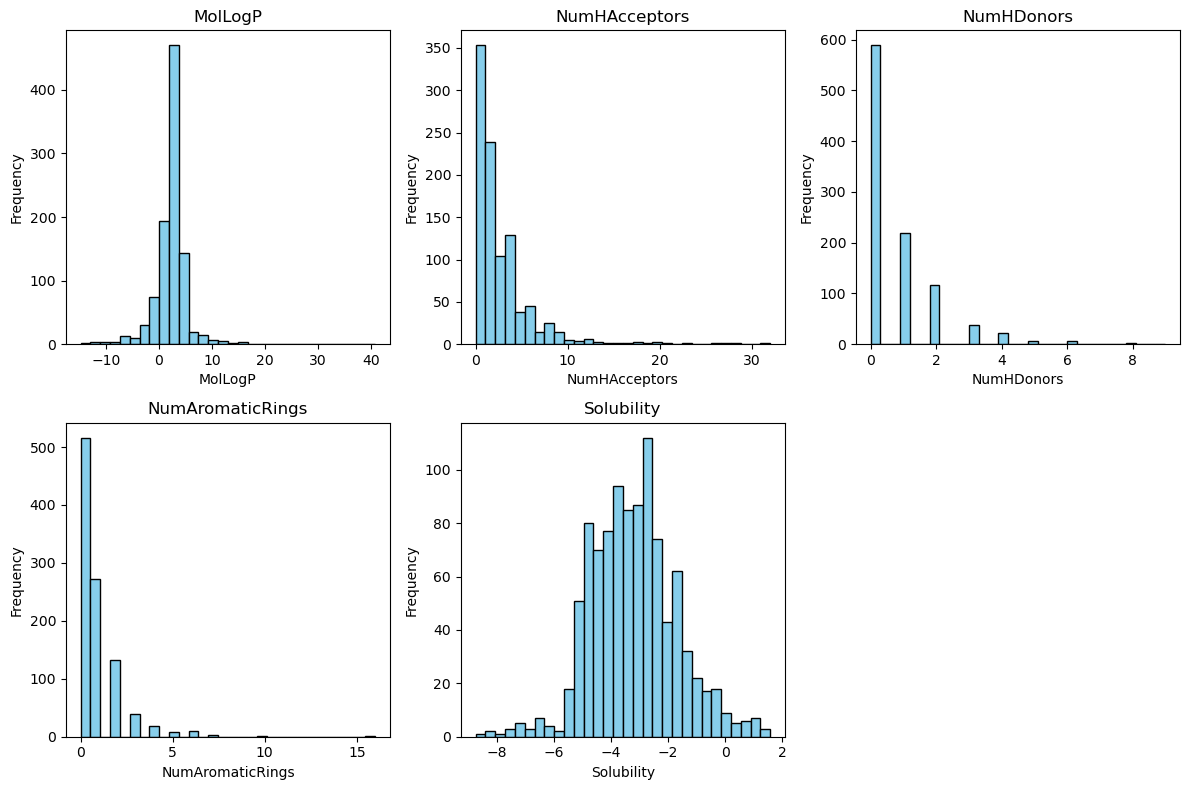

In [73]:
# Continuing with the reduced dataset
df = df[feature_cols + [target_col]]

# Redefining feature matrix and target vector
x = df[feature_cols]
y = df[target_col]

print("\nReduced df shape:", df.shape)
print(df.head())

# Check for obvious outliers using box plots (i love stats)
fig, axes = plt.subplots(1, 5, figsize=(16,4))
for i, col in enumerate(df.columns):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

# Quick visualization with histograms
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(len(df.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Outliers seem chemically reasonable edge cases (not errors), so I did not remove any rows. Boxplots and histograms show expected distributions from this df.

**Part b**

In [74]:
# 80/20 train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# regularization parameters
alphas = [1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'rmse': make_scorer(rmse, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results
cv_results = {"alpha": [], "rmse_mean": [], "rmse_std": [], "r2_mean": [], "r2_std": []}

for alpha in alphas:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, max_iter=10000, random_state=42))
    ])

    scores = cross_validate(
        pipe, x_train, y_train,
        cv = kf,
        scoring = scoring,
        return_train_score = False
    )

    cv_results["alpha"].append(alpha)
    cv_results["rmse_mean"].append(-scores["test_rmse"].mean())
    cv_results["rmse_std"].append(scores["test_rmse"].std())
    cv_results["r2_mean"].append(scores["test_r2"].mean())
    cv_results["r2_std"].append(scores["test_r2"].std())

In [75]:
cv_df = pd.DataFrame(cv_results)
print(cv_df)

      alpha  rmse_mean  rmse_std   r2_mean    r2_std
0     0.001   1.378981  0.044138  0.150259  0.074206
1     0.010   1.379524  0.044367  0.149713  0.072904
2     0.100   1.391049  0.049140  0.136056  0.068562
3     1.000   1.507301  0.074741 -0.010086  0.011525
4   100.000   1.507301  0.074741 -0.010086  0.011525
5  1000.000   1.507301  0.074741 -0.010086  0.011525


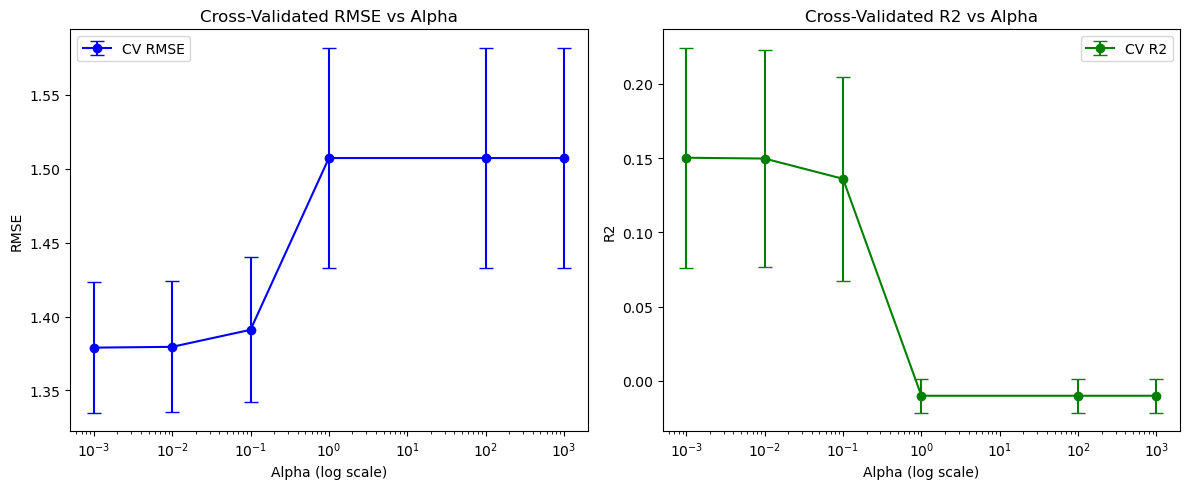

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# rmse plot
axes[0].errorbar(cv_df["alpha"], cv_df["rmse_mean"], yerr=cv_df["rmse_std"], fmt='o-', capsize=5, color='blue', label='CV RMSE')
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (log scale)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Cross-Validated RMSE vs Alpha')
axes[0].legend()

# r2 plot
axes[1].errorbar(cv_df["alpha"], cv_df["r2_mean"], yerr=cv_df["r2_std"], fmt='o-', capsize=5, color='green', label='CV R2')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (log scale)')
axes[1].set_ylabel('R2')
axes[1].set_title('Cross-Validated R2 vs Alpha')
axes[1].legend()

plt.tight_layout()
plt.show()

rmse is lowest at small alphas (1e-3, 1e-2). r2 is highest at those same small alphas

In [77]:
best_alpha = cv_df.loc[cv_df['rmse_mean'].idxmin(), 'alpha']
print("Best alpha based on CV RMSE:", best_alpha)

Best alpha based on CV RMSE: 0.001


In [78]:
# retrain on full training set with best alpha
final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(alpha=best_alpha, max_iter=10000, random_state=42))
])

final_pipe.fit(x_train, y_train)
y_pred = final_pipe.predict(x_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse:}")
print(f"Test R2: {test_r2:.4f}")

Test RMSE: 1.3520955482354664
Test R2: 0.1861


Comparing the cross-validated results and the held-out test results show close agreement. The mean cross-validated RMSE was about 1.38 with a std of 0.04, with the corresponding test RMSE being 1.35. Similarly, the cross-validated R2 was about 0.15 with a std of 0.07 with the corresponding test r2 being 0.186. This consistency suggests that the model is generalizing well to unseen data.

**Part c**

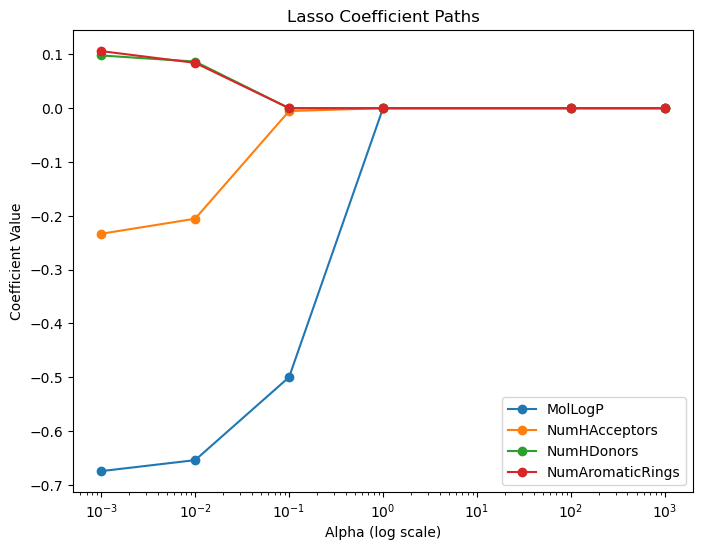

In [79]:
coef_paths = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(StandardScaler().fit_transform(x_train), y_train)
    coef_paths.append(lasso.coef_)

coef_paths = np.array(coef_paths)

plt.figure(figsize=(8, 6))
for i, col in enumerate(x.columns):
    plt.plot(alphas, coef_paths[:, i], marker='o', label=col)

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficient Paths')
plt.legend()
plt.show()

In [80]:
final_lasso = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
final_lasso.fit(StandardScaler().fit_transform(x_train), y_train)

coef_df = pd.DataFrame({
    "Feature": x.columns,
    "Coefficient": final_lasso.coef_
}). sort_values(by="Coefficient", key=np.abs, ascending=False)

print(coef_df)

            Feature  Coefficient
0           MolLogP    -0.674390
1     NumHAcceptors    -0.233353
3  NumAromaticRings     0.106029
2        NumHDonors     0.097957


MolLogP has the largest magnitude coefficient, indicating that it is the most important predictor of solubility. As alpha increases, the less important features shrink to zero first, while alpha remains the most significant the longest, confirming that solubility is most strongly tied to hydrophobicity which is captured by the MolLogP feature.

**Part d**

In [81]:
corr_matrix = x.corr(method='pearson')
print("Correlation matrix:\n", corr_matrix)

Correlation matrix:
                    MolLogP  NumHAcceptors  NumHDonors  NumAromaticRings
MolLogP           1.000000      -0.213912   -0.064148          0.163904
NumHAcceptors    -0.213912       1.000000    0.471099          0.450151
NumHDonors       -0.064148       0.471099    1.000000          0.349690
NumAromaticRings  0.163904       0.450151    0.349690          1.000000


In [82]:
corr_unstacked = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).unstack()

most_corr_pair = corr_unstacked.idxmax()
most_corr_value = corr_unstacked.max()

least_corr_pair = corr_unstacked.abs().idxmin()
least_corr_value = corr_unstacked.loc[least_corr_pair]

anti_corr_pair = corr_unstacked.idxmin()
anti_corr_value = corr_unstacked.min()

print(f"\nMost correlated pair: {most_corr_pair} with correlation {most_corr_value:.3f}")
print(f"Least correlated pair: {least_corr_pair} with correlation {least_corr_value:.3f}")
print(f"Most anti-correlated pair: {anti_corr_pair} with correlation {anti_corr_value:.3f}")


Most correlated pair: ('NumHDonors', 'NumHAcceptors') with correlation 0.471
Least correlated pair: ('NumHDonors', 'MolLogP') with correlation -0.064
Most anti-correlated pair: ('NumHAcceptors', 'MolLogP') with correlation -0.214


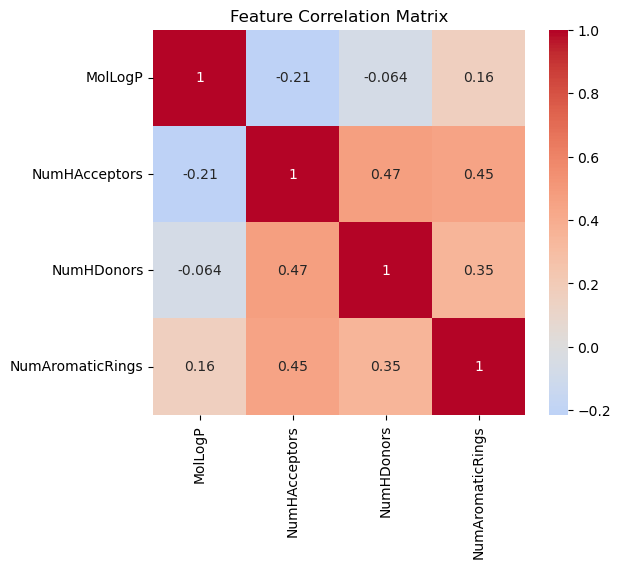

In [83]:
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Feature Correlation Matrix')
plt.show()

The most correlated pair of features is NumHDonors-NumHAcceptors, and the least correlated pair is NumHDonors-MolLogP. There are no strong anti-correlations, but the strongest would be with NumHAcceptors-MolLogP. These results show moderate redundancy, where NumHDonors and NumHAcceptors carry partially overlapping information so Lasso naturally down-weighted these redundant predictors. MolLogP is only weakly correlated with the other features, confirming why Lasso gives it the largest coefficient since it has unique information about the solubility. This analysis confirms my interpretation of the feature selection results from part c.

**Part e**

To introduce non-linearity, we could add a polynomial feature. For example we could include MolLogP^2 or interaction like MolLogP * NumAromatic Rings. This would allow the model to capture non-linear and/or interaction effects such as cases where solubility changes more steeply at extreme values of MolLogP. If the relationship between MolLogP and Solubility is not purely linear, this may improve the model's predictive power. On the other hand, this would increase the model complexity and introduce additional risk of overfitting (esp with a small dataset of 1000). It may make interpretation harder because the coefficients would no longer directly represent a linear effect.

# Problem 2: Molecular Featurization and Tanimoto (aka Jaccard) Similarity

**Part a**

In [84]:
df2 = pd.read_csv("Solubility.csv")
df2 = df2.head(1000)

smiles_list = df2['SMILES'].tolist()
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048) # Added this to circumvent the  "DepreciationWarning" that may have affected the molecule integrity
fps = [gen.GetFingerprint(mol) for mol in mols]

[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not removing hydrogen atom without neighbors
[14:53:05] WARNING: not r

In [85]:
def TanimotoSimilarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

In [86]:
n = len(fps)
sims = []

most_sim = (-1, None, None) # Gives me (similarity, i, j)
least_sim = (2, None, None) # Gives me (similarity, i, j)

for i in range(n):
    for j in range(i+1, n):
        sim = TanimotoSimilarity(fps[i], fps[j])
        sims.append(sim)

        if sim > most_sim[0]:
            most_sim = (sim, i, j)

        if sim < least_sim[0]:
            least_sim = (sim, i, j)

avg_sim = np.mean(sims)
std_sim = np.std(sims)

print(f"Most similar pair: {most_sim[1]} and {most_sim[2]} with similarity {most_sim[0]:.3f}")
print(f"Least similar pair: {least_sim[1]} and {least_sim[2]} with similarity {least_sim[0]:.3f}")
print(f"Average similarity: {avg_sim:.3f} ± {std_sim:.3f}")

Most similar pair: 15 and 265 with similarity 1.000
Least similar pair: 0 and 1 with similarity 0.000
Average similarity: 0.079 ± 0.070


**The average and standard deviation of all calculated pairwise similarities is 0.079 ± 0.070**

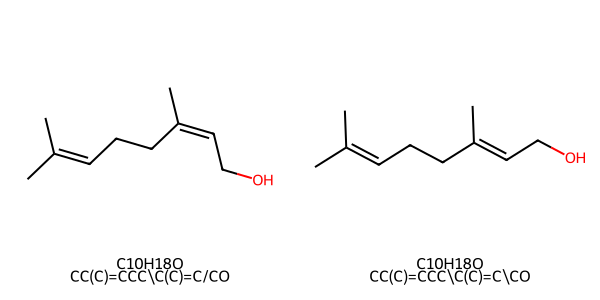

Most Similar Pair (Tanimoto Similarity: 1.000)


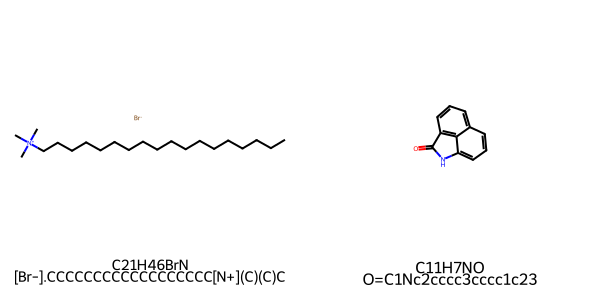

Least Similar Pair (Tanimoto Similarity: 0.000)


In [87]:
most_sim_smiles = (smiles_list[most_sim[1]], smiles_list[most_sim[2]])
least_sim_smiles = (smiles_list[least_sim[1]], smiles_list[least_sim[2]])

most_sim_mols = [Chem.MolFromSmiles(smiles) for smiles in most_sim_smiles]
least_sim_mols = [Chem.MolFromSmiles(smiles) for smiles in least_sim_smiles]

def make_pair_image(mols, smiles_pair, title, sim_score):
    formulas = [rdMolDescriptors.CalcMolFormula(mol) for mol in mols]
    legends = [f"{formulas[i]}\n{smiles_pair[i]}" for i in range(len(mols))] 

    img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(300,300), legends=legends)
    display(img)
    print(f"{title} (Tanimoto Similarity: {sim_score:.3f})")

make_pair_image(most_sim_mols, most_sim_smiles, "Most Similar Pair", most_sim[0])
make_pair_image(least_sim_mols, least_sim_smiles, "Least Similar Pair", least_sim[0])